In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import AutoModelForCausalLM

In [2]:
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-v0.1",
    device_map="cpu",
)
for p in model.parameters():
    p.requires_grad = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
unembed, embed = model.lm_head, model.model.embed_tokens

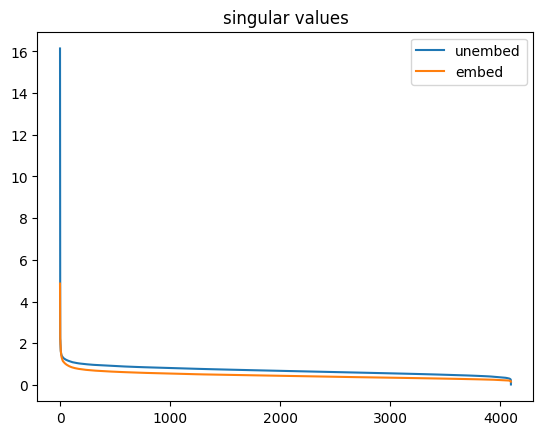

In [4]:
# compute RSVs of unembed matrix
with torch.no_grad():
    Uu, Su, Vhu = torch.linalg.svd(unembed.weight.cuda(), driver="gesvdj")
    Ue, Se, Vhe = torch.linalg.svd(embed.weight.cuda(), driver="gesvdj")

plt.plot(Su.cpu().numpy(), label="unembed")
plt.plot(Se.cpu().numpy(), label="embed")
plt.title("singular values")
plt.legend()
plt.show()

In [5]:
model.model.layers[0]

MistralDecoderLayer(
  (self_attn): MistralSdpaAttention(
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
    (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (rotary_emb): MistralRotaryEmbedding()
  )
  (mlp): MistralMLP(
    (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
    (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): MistralRMSNorm()
  (post_attention_layernorm): MistralRMSNorm()
)

In [6]:
model.model.layers[0].self_attn.o_proj.weight.shape

torch.Size([4096, 4096])

In [7]:
@torch.no_grad()
def project(module, unembed=True, head_idx="aggr"):
    # projects weight onto unembed/embed space
    if module.weight.shape[-1] != Vhe.shape[0]:
        proj_weight = module.weight.T
    else:
        if isinstance(head_idx, int):
            head_dim = module.weight.shape[0] // model.config.num_attention_heads
            proj_weight = module.weight[
                head_idx * head_dim : (head_idx + 1) * head_dim, :
            ]
        else:
            proj_weight = module.weight
    rsv = Vhu if unembed else Vhe
    return torch.norm(rsv @ proj_weight.cuda().T, dim=-1, p=2).squeeze().cpu().numpy()


def plot_projections(layer_indices, unembed=True, head_indices="aggr"):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    axs = axs.flatten()

    if isinstance(head_indices, list) and len(layer_indices) == 1:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(head_indices)))
        mode = "multi_head"
    else:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(layer_indices)))
        mode = "multi_layer"
        head_indices = ["aggr"]

    for idx, layer_idx in enumerate(layer_indices):
        layer = model.model.layers[layer_idx]
        w1 = layer.mlp.up_proj
        w2 = layer.mlp.down_proj
        w3 = layer.mlp.gate_proj
        wo = layer.self_attn.o_proj

        layers = [w1, w2, w3, wo]
        labels = ["up (w1)", "down (w2)", "gate (w3)", "o (wo)"]

        for ax, layer, label in zip(axs, layers, labels):
            if label == "o (wo)":
                if mode == "multi_head":
                    for head_idx, color in zip(head_indices, colors):
                        projection = project(layer, unembed=unembed, head_idx=head_idx)
                        ax.scatter(
                            range(len(projection)),
                            projection,
                            s=1,
                            color=color,
                            alpha=0.7,
                            label=f"Head {head_idx}",
                        )
                else:
                    projection = project(layer, unembed=unembed, head_idx="aggr")
                    ax.scatter(
                        range(len(projection)),
                        projection,
                        s=1,
                        color=colors[idx],
                        alpha=0.7,
                        label=f"Layer {layer_idx}",
                    )
            else:
                projection = project(layer, unembed=unembed, head_idx="aggr")
                ax.scatter(
                    range(len(projection)),
                    projection,
                    s=1,
                    color=colors[idx] if mode == "multi_layer" else "blue",
                    alpha=0.7,
                    label=f"Layer {layer_idx}" if mode == "multi_layer" else None,
                )

            ax.set_title(label)
            ax.legend(loc="upper right", fontsize="x-small")

    if mode == "multi_head":
        plt.suptitle(
            f"Projections for Layer {layer_indices[0]}, Heads {', '.join(map(str, head_indices))} {'(unembed)' if unembed else '(embed)'}",
            fontsize=20,
        )
    else:
        plt.suptitle(
            f"Projections for Layers {', '.join(map(str, layer_indices))} {'(unembed)' if unembed else '(embed)'}",
            fontsize=20,
        )

    plt.tight_layout()
    plt.show()

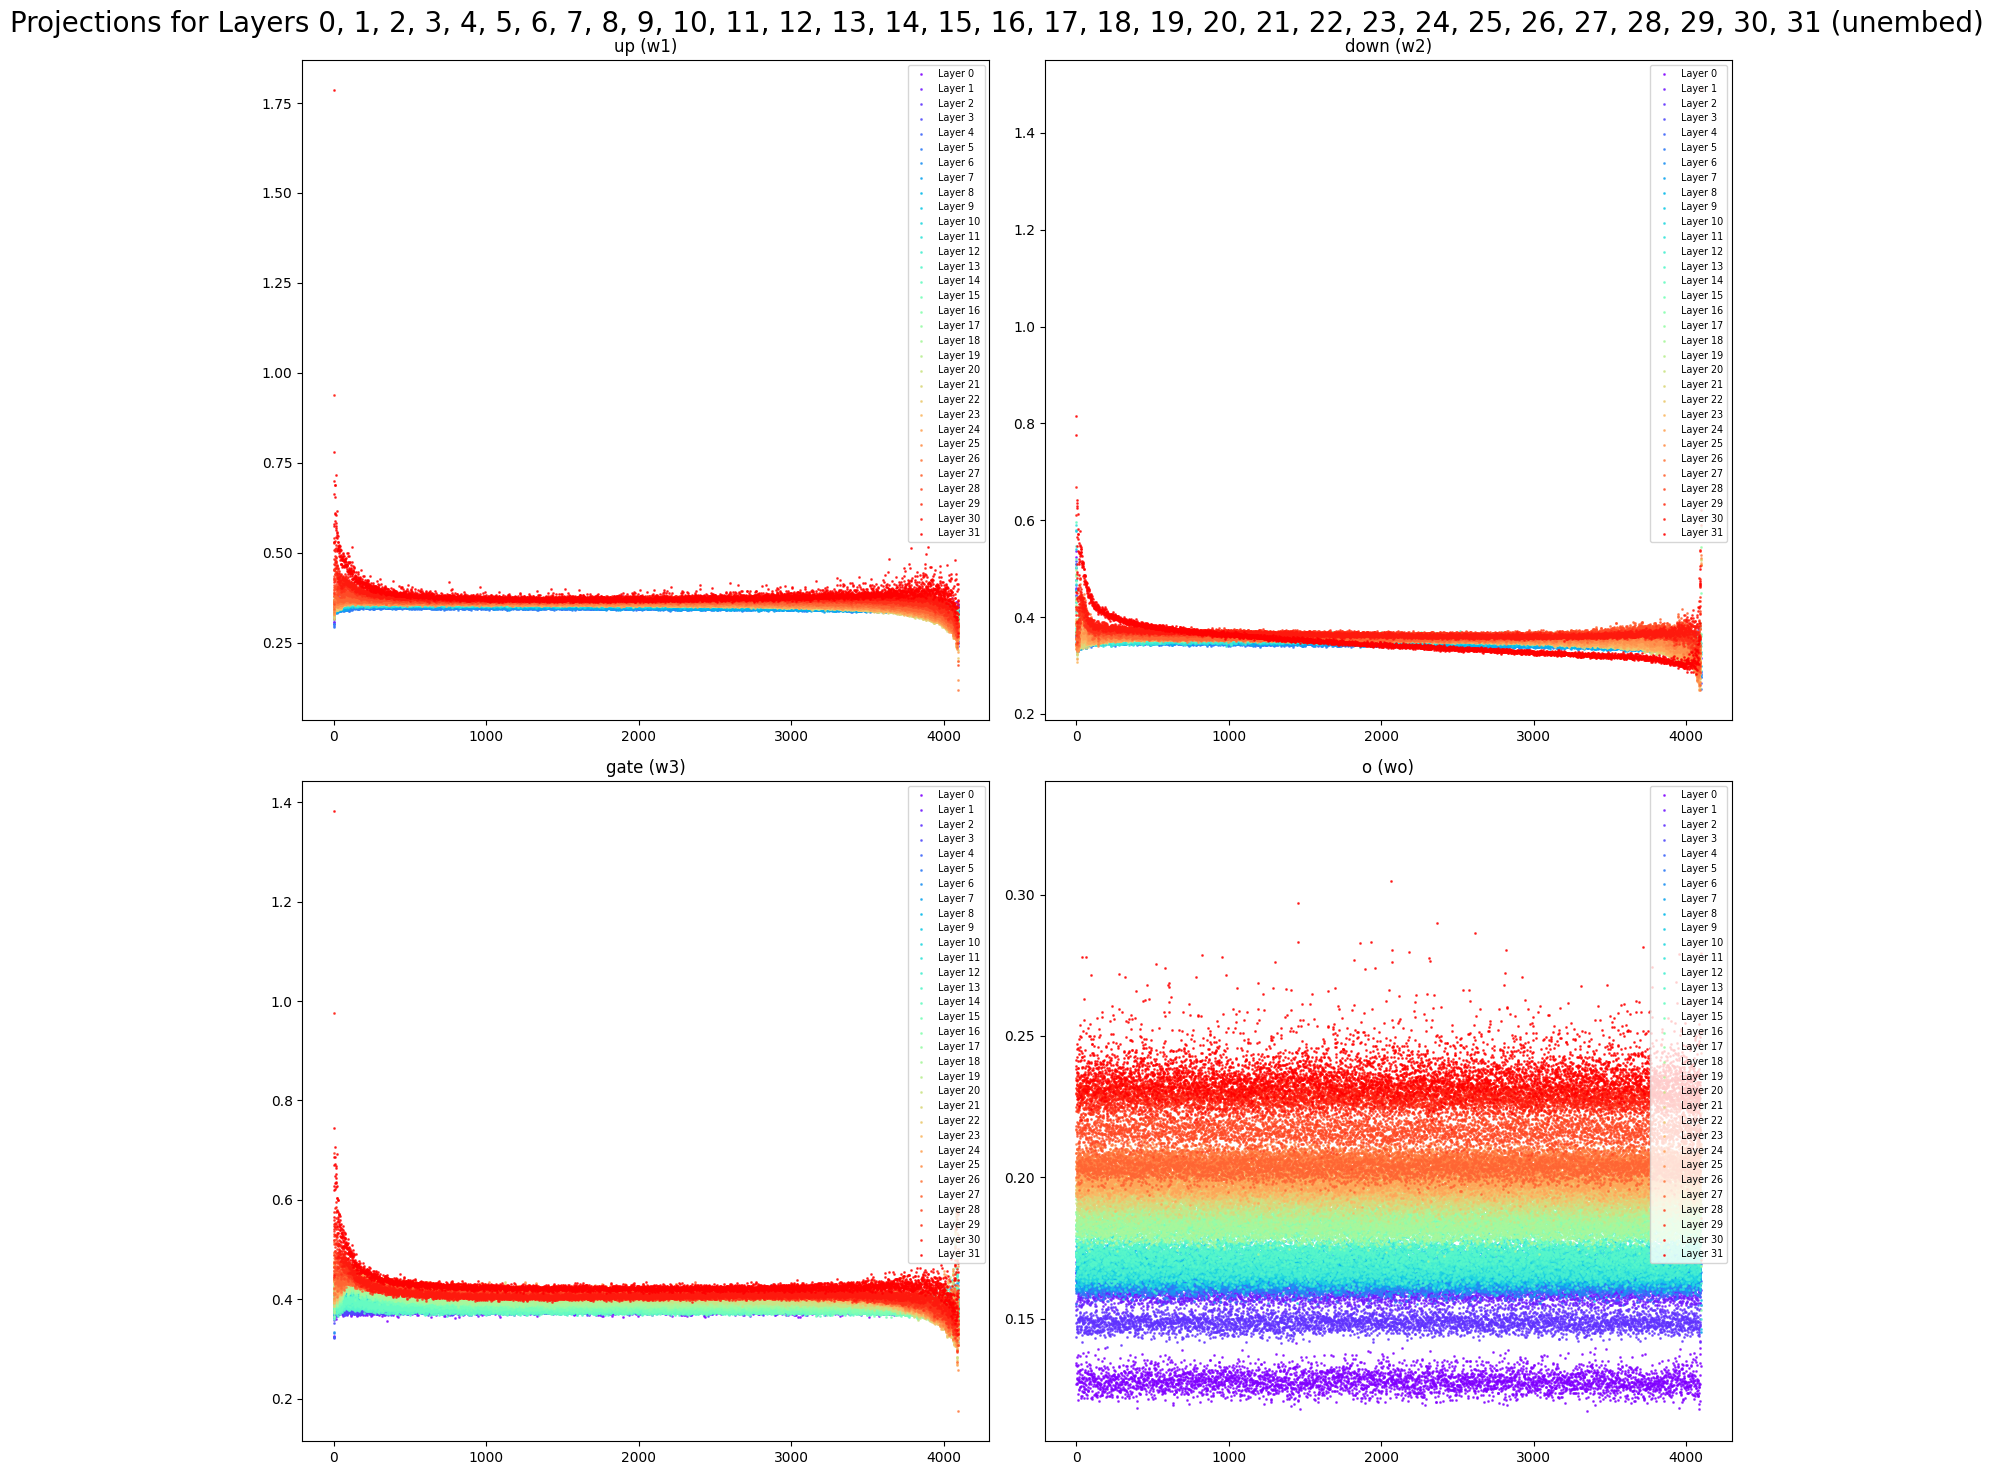

In [8]:
plot_projections(range(len(model.model.layers)), unembed=True)

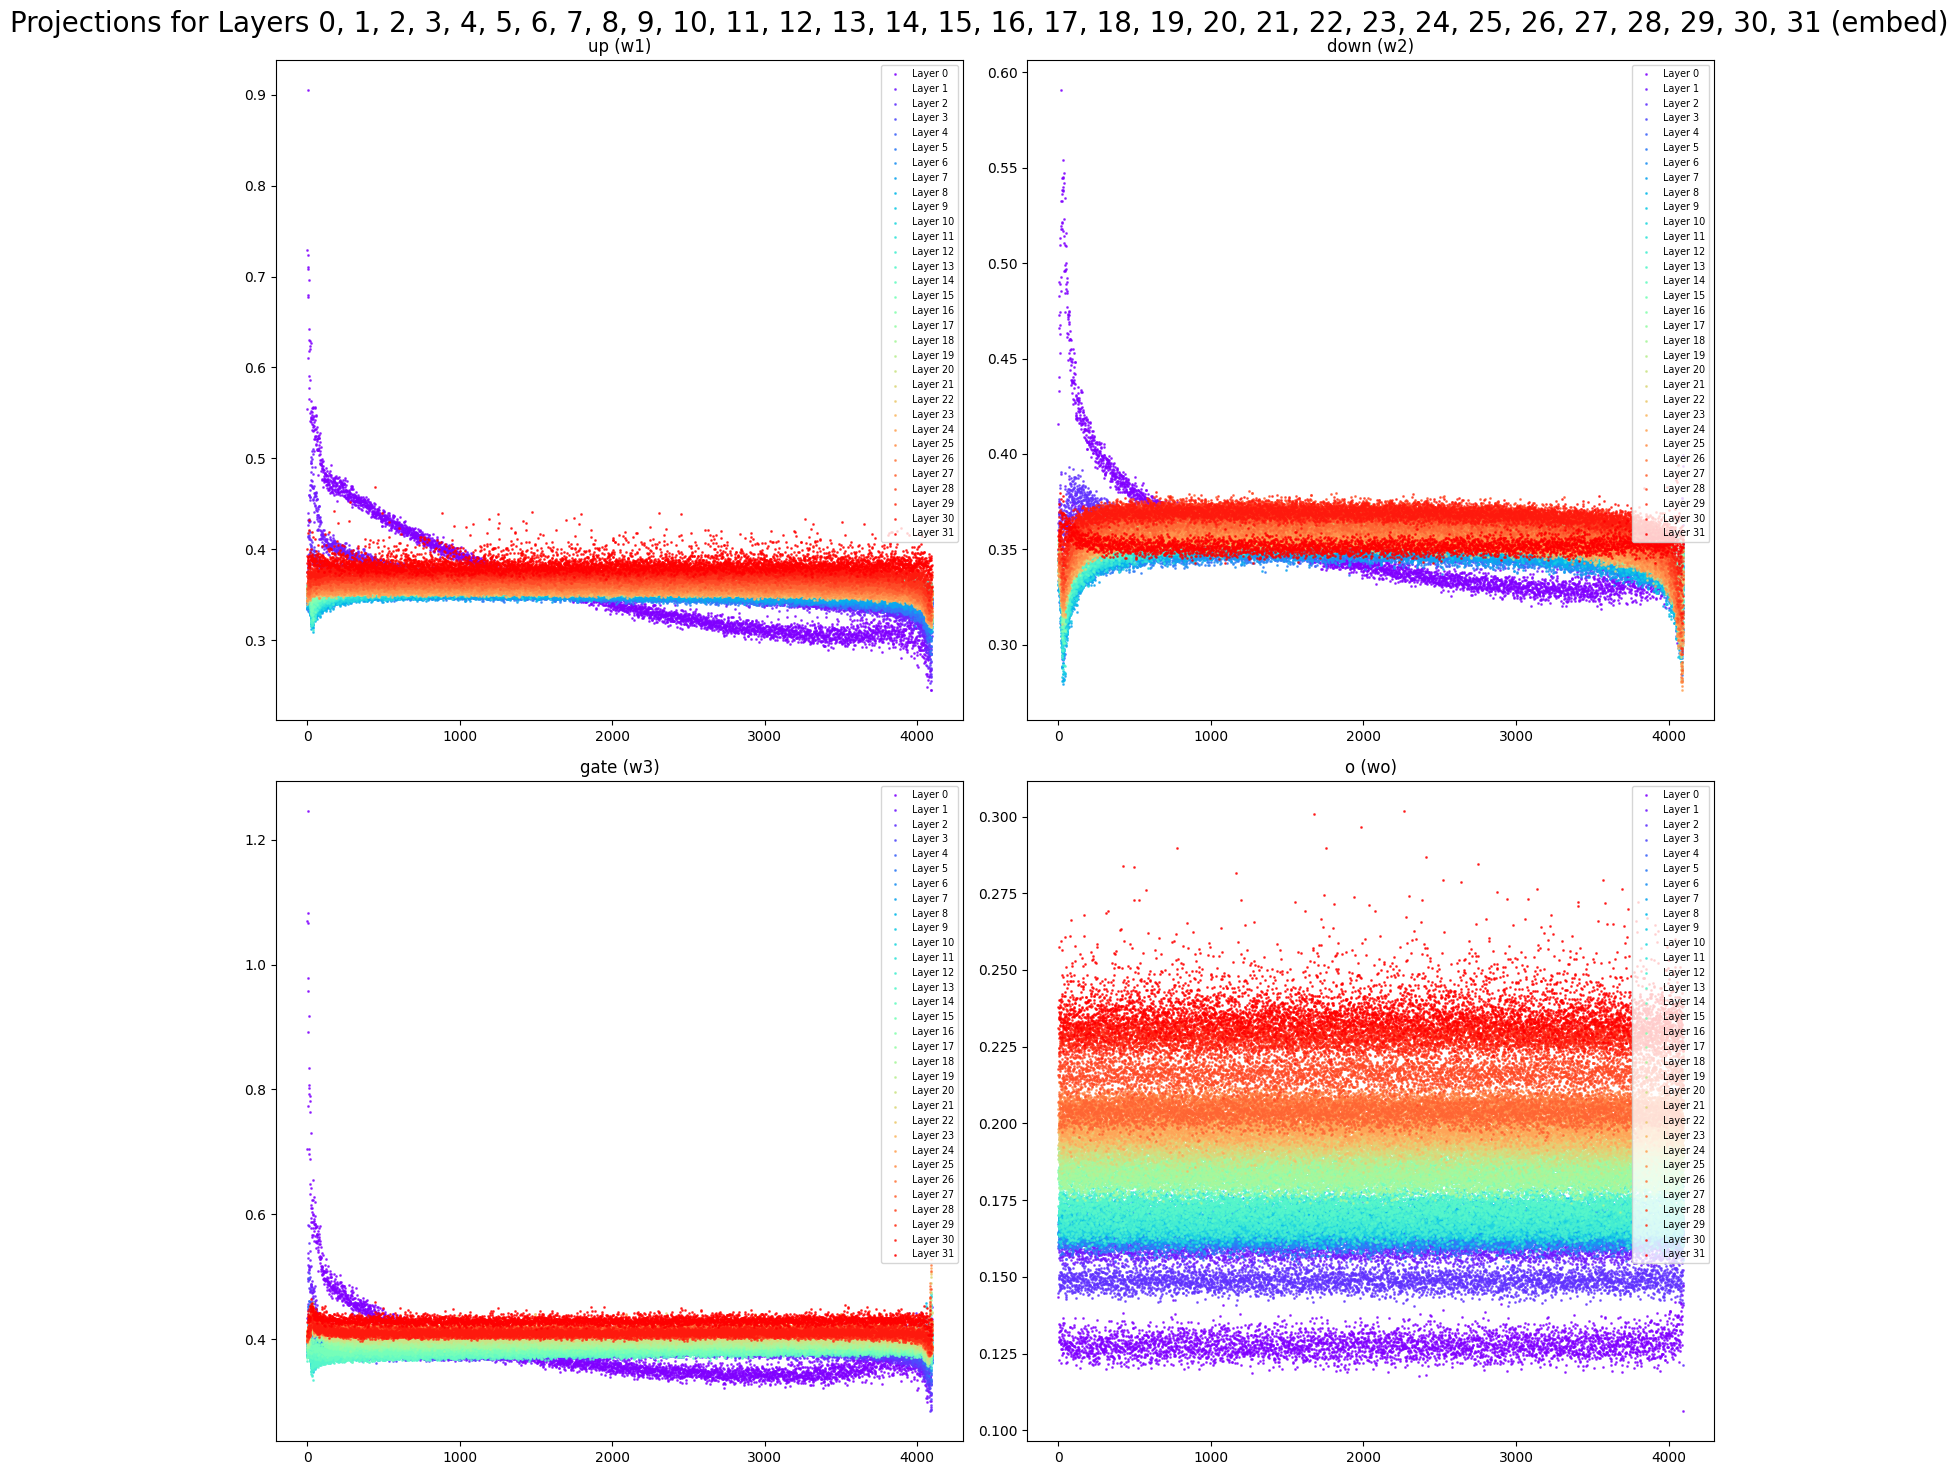

In [9]:
plot_projections(range(len(model.model.layers)), unembed=False)
# plot_projections([regular_block_indices[0], regular_block_indices[-1]])
# plot_projections([regular_block_indices[0], regular_block_indices[-1]], unembed=False)